# Social Reward Modeling

Social reward task computational modeling from the DSCN Lab Social Connection (SCONN) project. These analyses will propose computational models that aim to explain participants' behavior during a task in which they learn about a similar peer, dissimilar peer, and a computer. Similarity is defined as common interest from a survey that asked participants whether they enjoy certain things (e.g. reading, hiking, etc.).

## Set Up

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt


import importlib
import rl_functions
importlib.reload(rl_functions)

<module 'rl_functions' from '/Users/hpopal/Library/CloudStorage/GoogleDrive-hpopal@umd.edu/My Drive/dscn_lab/projects/scon_social_reward/code/rl_functions.py'>

### Set Paths

In [2]:
if os.path.isdir('/Users/hpopal'):
    proj_dir = '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/scon_social_reward/'
else:
    proj_dir = '/Users/haroonpopal/hpopal@umd.edu - Google Drive/My Drive/dscn_lab/projects/scon_social_reward/'

data_dir = os.path.join(proj_dir, 'derivatives', 'task_socialreward', 'data')
outp_dir = os.path.join(proj_dir, 'derivatives', 'rl_modeling')

os.chdir(proj_dir)

## Model Designs

RPE<sub>t</sub> = Feedback<sub>t</sub> - V<sub>t</sub>

V<sub>t+1</sub> = V<sub>t</sub> + $\alpha$ * RPE<sub>t</sub>

### Model 1: Generative Rescorla Wagner

This is a generative model which assumes a common learning rate for all participants. The model takes as input a trial list, which contains information about the conditions (similar, dissimilar, or computer), and feedback (thumbs up or down) for each trial, and returns the following outputs: expected value of the three conditions on each trial, and reward prediction error. There is no value calculation based on choices or reaction times to a button press. 

### Model 2: Rescorla Wagner + Random RT
This model uses reaction time to calculate the value of each condition, for each trial. However, the reaction times are simulated to be random. This serves as the null model. 

### Model 3: Rescorla Wagner + Value Differentiation RT
- Reaction time is calculated from value, but is dependent on how well each condition can be differentiated
- Once conditions are learned to be more seperate, reaction times will be faster
- https://pmc.ncbi.nlm.nih.gov/articles/PMC8930195/
    - RTt = -B|Vpst - Vpdt - Vct| + error
        - B = 1
        - Vpst = value of peer similar at t
        - Vpdt = value of peer dissimilar at t
        - Vct = value of computer at t
        - error = Gaussian random noise, with mean = 1 and SD = 5 * SD of |Vpst - Vpdt - Vct|
- Note: I don't see how this model is any different from a model which predicts participants to just get faster because of practice effects.

### Model 4: Rescorla Wagner + RT Value
- Reaction time is directly based on the value of the condition
- Hypothesis: Higher value and faster reaction time for the similar peer, low value and slower reaction time for dissimilar peer, and neutral value and no change in reaction time for computer.

### Model 5: Rescorla Wagner + RT Social Value
- Reaction time is directly based on the value of the condition
- Higher value and lower reaction times for the social peers (similar and dissimilar) rather than computer

### Model 6: RW + RT Value + Item Value
- Model 4, but with an additional parameter for the explicit value of each item (as indicated by a participant pre-task survey) that amplifies the value
- This model accounts that participants care for some items more than others
- For example, if I really enjoy reading books, and the peer does not, there is extra dissappointment (negative reward). But if I only moderately enjoy reading, and the peer does not, then there is less dissappointment).

### Model 7: RW + RT Value with modified reward
- Model 4, but the rewards for each outcome are changes such that negative feedback offers some reward (0.5)
- Participants may still be motivated to learn about the peers, regardless of the valence of the feedback

### Model 8: RW + RT Value with modified reward per condition
- Model 4, but the rewards for each outcome are changes such that negative feedback for peers offers some reward (0.5)
- Positive feedback for the computer offers half reward (0.5)
- Participants may still be motivated to learn about the peers, regardless of the valence of the feedback

### Model 9: Rescorla Wagner + RT Surprise Value

RPE<sub>t</sub> = Feedback<sub>t</sub> - S<sub>t</sub>

S<sub>t+1</sub> = S<sub>t</sub> + $\alpha$ * |RPE<sub>t</sub>|

- Reaction time is directly based on the surprise of the condition
- Hypothesis: Higher surprise and slower reaction time for higher reward prediciton errors

### Model Summaries

| Model | Parameters | Hypothesis |
| ----- | ---------- | ---------- |
| Model 1 | none | No RT |
| Model 2 | RT ~ $\beta$ * rand(0.25, 2.0) + intercept | value is not dependent on reaction time |
| Model 3 | RT ~ -$\beta$ * abs(Vpst - Vpdt - Vct) + intercept | reaction time increases as participants learn the condition values |
| Model 4 | RT ~ $\beta$ * -1 * Vpeer + intercept | negative relationship between value and reaction time |
| Model 5 | RT ~ $\beta$ * -1 * Vpeer + intercept,<br>if peer = similar: $\beta$; if peer = dissimilar: $\beta$ = -1 * $\beta$; if peer = computer: $\beta$ = 0 | faster reaction times for social > computer |
| Model 6 | RT ~ $\beta$ * -1 * Vpeer * Vitem + intercept | negative relationship between value and reaction, amplified by inherent item value |
| Model 7 | RT ~ $\beta$ * -1 * Vpeer + intercept,<br>negative reward = 0.5; positive reward = 1 | negative relationship between value and RT for social peer conditions, but not computer condition |
| Model 8 | RT ~ $\beta$ * -1 * Vpeer + intercept,<br>if condition = peer: negative reward = 0.5, positive reward = 1; if condition = computer: negative reward = 0, positive reward = 0.5 | negative relationship between value and RT for social peer conditions, but not computer condition |



## Simulate Data

### Define simulation function
This function takes in the number of trials as input and outputs a simulated task with the correction distribution of trial types. 

In [3]:
def simulate_data(n_trials):
    # Define the proportion of positive and negative feedback for each peer condition
    # 96 is used as the denominator bceause that is the number of trials in the task, but
    # more trials can be simulated here
    prop_ps_pos = 24/96
    prop_ps_neg = 8/96
    prop_pd_pos = 8/96
    prop_pd_neg = 24/96
    prop_c_pos = 16/96
    prop_c_neg = 16/96

    # Define an empty dataframe
    peer_data = []
    fb_data = []

    # Add feedback data for positive and negative feedback
    peer_data = peer_data + (['SimPeer'] * int(prop_ps_pos * n_trials))
    fb_data = fb_data + ([1] * int(prop_ps_pos * n_trials))
    peer_data = peer_data + (['SimPeer'] * int(prop_ps_neg * n_trials))
    fb_data = fb_data + ([-1] * int(prop_ps_neg * n_trials))
    peer_data = peer_data + (['DisPeer'] * int(prop_pd_pos * n_trials))
    fb_data = fb_data + ([1] * int(prop_pd_pos * n_trials))
    peer_data = peer_data + (['DisPeer'] * int(prop_pd_neg * n_trials))
    fb_data = fb_data + ([-1] * int(prop_pd_neg * n_trials))
    peer_data = peer_data + (['Computer'] * int(prop_c_pos * n_trials))
    fb_data = fb_data + ([1] * int(prop_c_pos * n_trials))
    peer_data = peer_data + (['Computer'] * int(prop_c_neg * n_trials))
    fb_data = fb_data + ([-1] * int(prop_c_neg * n_trials))

    sim_data_dict = {'Peer': peer_data, 'Feedback': fb_data} 
    sim_data = pd.DataFrame(sim_data_dict)

    # Create item interest data
    n_pos_data = len(sim_data[sim_data['Feedback'] == 1])
    n_neg_data = len(sim_data[sim_data['Feedback'] == -1])

    interest_pos = [1] * int(.75 * n_pos_data) + [2] * int(.25 * n_pos_data)
    interest_neg = [-1] * int(.75 * n_neg_data) + [-2] * int(.25 * n_neg_data)

    # Randomize
    np.random.shuffle(interest_pos)
    np.random.shuffle(interest_neg)

    sim_data['Interest'] = 0
    sim_data.loc[sim_data[sim_data['Feedback'] == 1].index,'Interest'] = interest_pos
    sim_data.loc[sim_data[sim_data['Feedback'] == -1].index,'Interest'] = interest_neg

    sim_data = sim_data.sample(frac=1).reset_index(drop=True)

    sim_data['Trial'] = (range(1,n_trials+1))

    return(sim_data)

### Define model simulation function
This function takes in a particular model and runs a simulation with the appropriate parameters.

In [4]:
def run_rl_model(model, alphas, beta, intercept, neg_reward, sim_data, sim=True):
    # Create empty dataframe to store data
    model_data = pd.DataFrame()

    if 'Run' in sim_data.columns:
        n_sims = sim_data['Run'].max()
        iter_colname = 'Run'
        iter_names = sim_data['Run'].unique()

        for alpha in alphas:
            # Filter for one simulation's data
            #sim_data = simulate_data(n_trials)
            #sim_data_temp = sim_data[sim_data[iter_colname] == i_iter].copy()
            #sim_data_temp = sim_data_temp.reset_index(drop=True)
            
            # Run models
            model_data_temp = model(sim_data, alpha, beta, intercept, neg_reward=neg_reward)
            model_data_temp[iter_colname] = sim_data['Run'].copy()
            model_data_temp['RT_actual'] = sim_data['First_RT'].copy()
            model_data_temp['alpha'] = alpha
            model_data_temp['beta'] = beta
        
            model_data = pd.concat([model_data, model_data_temp])
        
    else:
        n_sims = sim_data['n_sim'].max() + 1
        iter_colname = 'n_sim'
        iter_names = sim_data['n_sim'].unique()

        for i_iter in iter_names:
            for alpha in alphas:
                # Filter for one simulation's data
                #sim_data = simulate_data(n_trials)
                sim_data_temp = sim_data[sim_data[iter_colname] == i_iter].copy()
                sim_data_temp = sim_data_temp.reset_index(drop=True)
                
                # Run models
                model_data_temp = model(sim_data_temp, alpha, beta, intercept, neg_reward=neg_reward)
                model_data_temp[iter_colname] = i_iter
                model_data_temp['alpha'] = alpha
                model_data_temp['beta'] = beta
            
                model_data = pd.concat([model_data, model_data_temp])

    # Turn index into time point
    model_data['trial'] = model_data.index
    model_data_long = pd.melt(model_data, id_vars=[iter_colname,'Peer','RPE','RT','alpha','trial','Interest'], 
                              var_name='Condition',
                              value_vars=['SimPeer','DisPeer','Computer'], value_name='Value')

    return(model_data, model_data_long)


### Simulate models

#### Simulate Data

In [5]:
# Define number of simulations, and trials per simulation
n_sims = 1000
n_trials = 96


# Check if simulated data already exists
if os.path.isfile(outp_dir + '/simulated_data.csv'):
    sim_data = pd.read_csv(outp_dir + '/simulated_data.csv')

else:
    # Create a dataframe to store all the simulation data
    sim_data = pd.DataFrame()

    # Produce simulation data
    for n_sim in range(n_sims):
        # Run simulation function
        temp_sim_data = simulate_data(n_trials)
        temp_sim_data['n_sim'] = n_sim

        # Comebine with the rest of the data
        sim_data = pd.concat([sim_data, temp_sim_data])

    # Export data
    sim_data.to_csv(outp_dir + '/simulated_data.csv', index=False)

sim_data.head()

,Peer,Feedback,Interest,Trial,n_sim
0,SimPeer,1,2,1,0
1,DisPeer,1,1,2,0
2,SimPeer,-1,-1,3,0
3,Computer,1,1,4,0
4,SimPeer,1,1,5,0


#### Simulated Data Information
- Peer
    - Trial condition
- Feedback
    - 1 = positive feedback, -1 = negative feedback
- Interest
    - -2 = strong dislike, -1 = dislike, 1 = like, 2 = strong like
- Trial
    - Number trial for a given simulation
- n_sim
    - Number indicated the simulation

In [6]:
model_1, model_1_long = run_rl_model(model=rl_functions.rw_model, alphas=[0.05, 0.1, 0.5], beta=1, intercept=1, neg_reward=False,
                                     sim_data=sim_data)
model_2, model_2_long = run_rl_model(model=rl_functions.rw_randrt_model, alphas=[0.05, 0.1, 0.5], beta=1, intercept=1, neg_reward=False,
                                     sim_data=sim_data)
model_3, model_3_long = run_rl_model(model=rl_functions.rw_rtvaldiff_model, alphas=[0.05, 0.1, 0.5], beta=1, intercept=1, neg_reward=False,
                                     sim_data=sim_data)
model_4, model_4_long = run_rl_model(model=rl_functions.rw_rt_model, alphas=[0.05, 0.1, 0.5], beta=1, intercept=1, neg_reward=False,
                                     sim_data=sim_data)
model_5, model_5_long = run_rl_model(model=rl_functions.rw_rtsocial_model, alphas=[0.05, 0.1, 0.5], beta=1, intercept=1, neg_reward=False,
                                     sim_data=sim_data)
model_6, model_6_long = run_rl_model(model=rl_functions.rw_item_model, alphas=[0.05, 0.1, 0.5], beta=1, intercept=1, neg_reward=False,
                                     sim_data=sim_data)
model_7, model_7_long = run_rl_model(model=rl_functions.rw_rt_modreward_model, alphas=[0.05, 0.1, 0.5], beta=1, intercept=1, neg_reward=False,
                                     sim_data=sim_data)
model_8, model_8_long = run_rl_model(model=rl_functions.rw_rt_modreward2_model, alphas=[0.05, 0.1, 0.5], beta=1, intercept=1, neg_reward=False,
                                     sim_data=sim_data)
model_9, model_9_long = run_rl_model(model=rl_functions.rw_spr_model, alphas=[0.05, 0.1, 0.5], beta=1, intercept=1, neg_reward=False,
                                     sim_data=sim_data)


### Plot model parameters

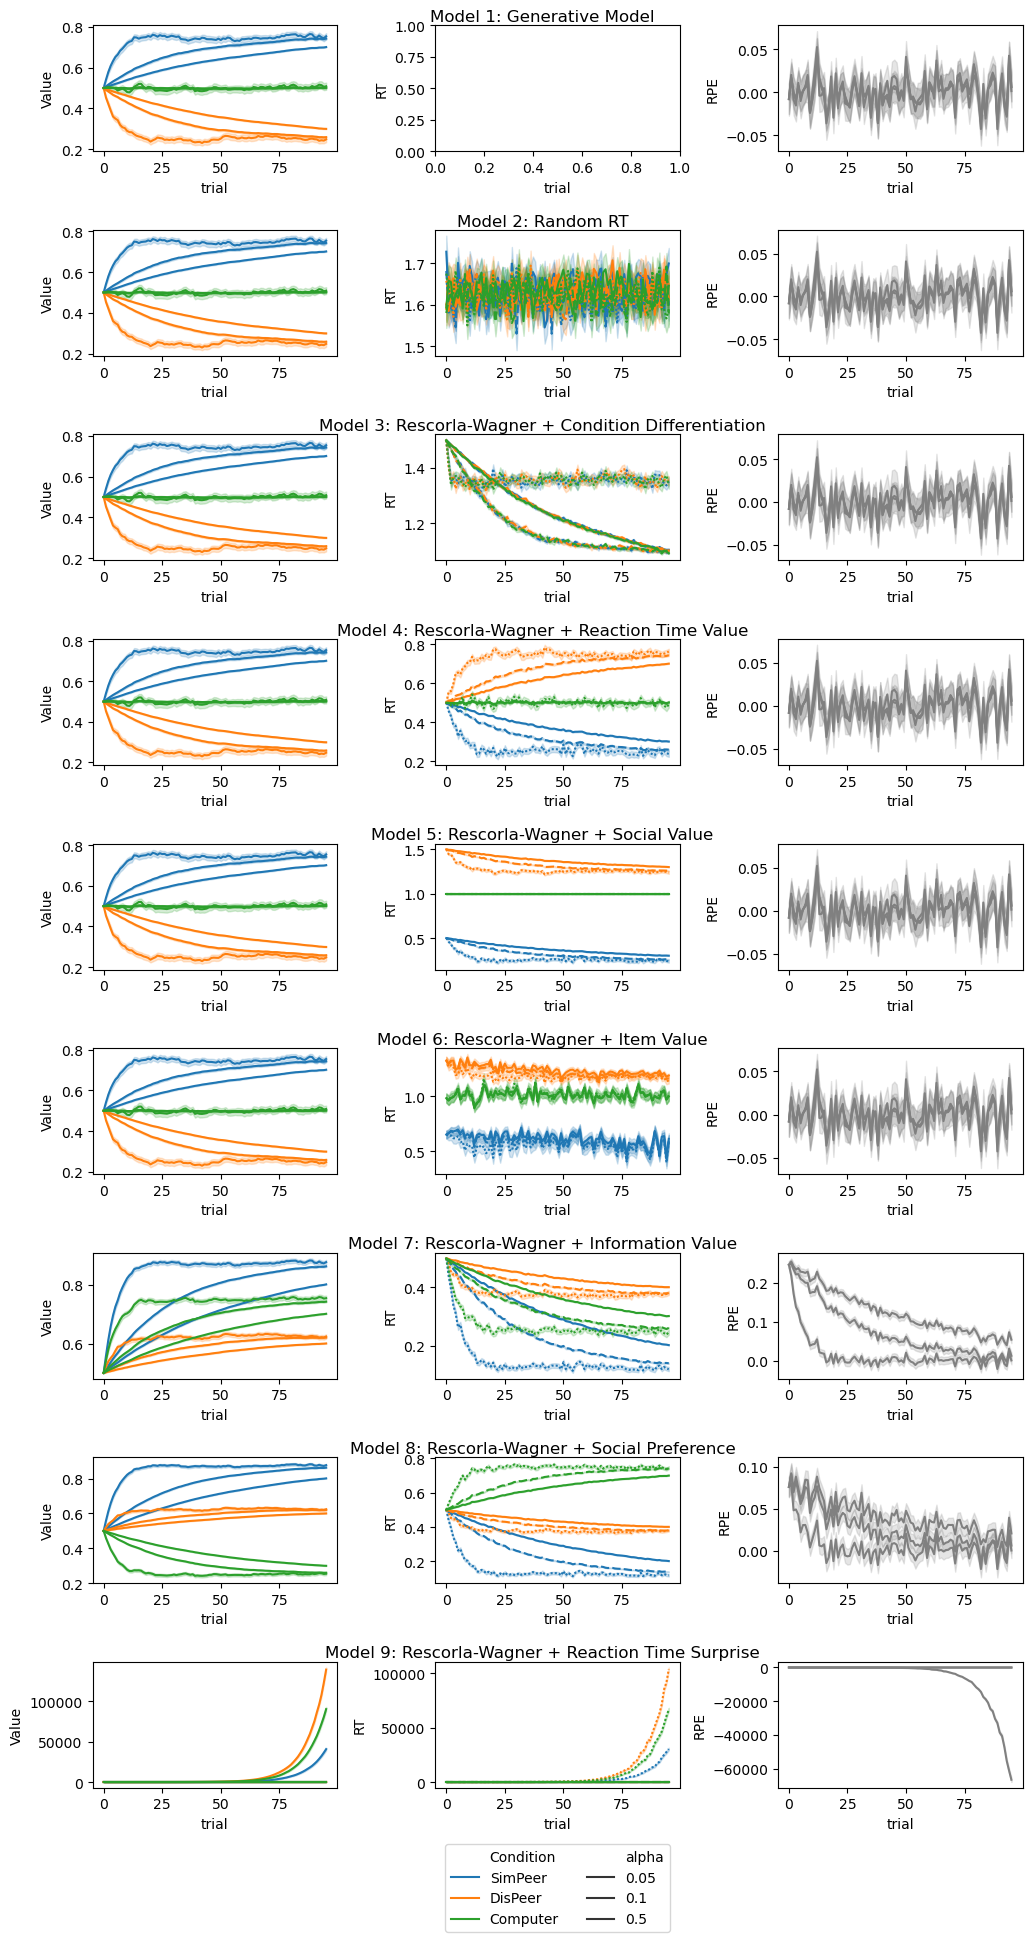

In [7]:
relv_models = [model_1_long, model_2_long, model_3_long,
               model_4_long, model_5_long, model_6_long,
               model_7_long, model_8_long, model_9_long]
relv_titles = ['Model 1: Generative Model',
               'Model 2: Random RT',
               'Model 3: Rescorla-Wagner + Condition Differentiation',
               'Model 4: Rescorla-Wagner + Reaction Time Value', 
               'Model 5: Rescorla-Wagner + Social Value', 
               'Model 6: Rescorla-Wagner + Item Value', 
               'Model 7: Rescorla-Wagner + Information Value', 
               'Model 8: Rescorla-Wagner + Social Preference',
               'Model 9: Rescorla-Wagner + Reaction Time Surprise']

palette = {'SimPeer':sns.color_palette()[0],
           'DisPeer':sns.color_palette()[1],
           'Computer':sns.color_palette()[2]}

fig = plt.figure(figsize=(12,2*len(relv_models)))
#fig.suptitle('Figure title')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=len(relv_models), ncols=1, hspace=0.25)
#subfigs.subplots_adjust(hspace=2)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(relv_titles[row])
    plt.subplots_adjust(wspace=0.4)

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
        #ax.plot()
        #ax.set_title(f'Plot title {col}')

    # Plot Value
    sns.lineplot(data=relv_models[row], x='trial', y='Value', dashes=False, 
                 hue='Condition', style='alpha', ax=axs[0])
    axs[0].set_ylabel('Value')
    if row == len(relv_models)-1:
        plt.setp(axs[0].get_legend().legend_handles, markeredgewidth=1)
        sns.move_legend(axs[0], "lower center", bbox_to_anchor=(1.9, -1.2), ncol = 2)
        #sns.move_legend(axs[0], "lower center", bbox_to_anchor=(1.9, -1), 
        #           labels=['Similar Peer','Dissimilar Peer','Computer'], ncol=3)
    else:
        axs[0].get_legend().remove()
    
    #axs[row,0].set_title(relv_titles[i])
        
        
    # Plot reaction time
    sns.lineplot(data=relv_models[row], x='trial', y='RT', 
                 hue='Peer', style='alpha', ax=axs[1], palette=palette)
    axs[1].get_legend().remove()
    axs[1].set_ylabel('RT')
        
        
    # Plot reward prediction error
    sns.lineplot(data=relv_models[row], x='trial', y='RPE', style='alpha',
                 dashes=False, ax=axs[2], color='grey')
    axs[2].get_legend().remove()
    axs[2].set_ylabel('RPE')

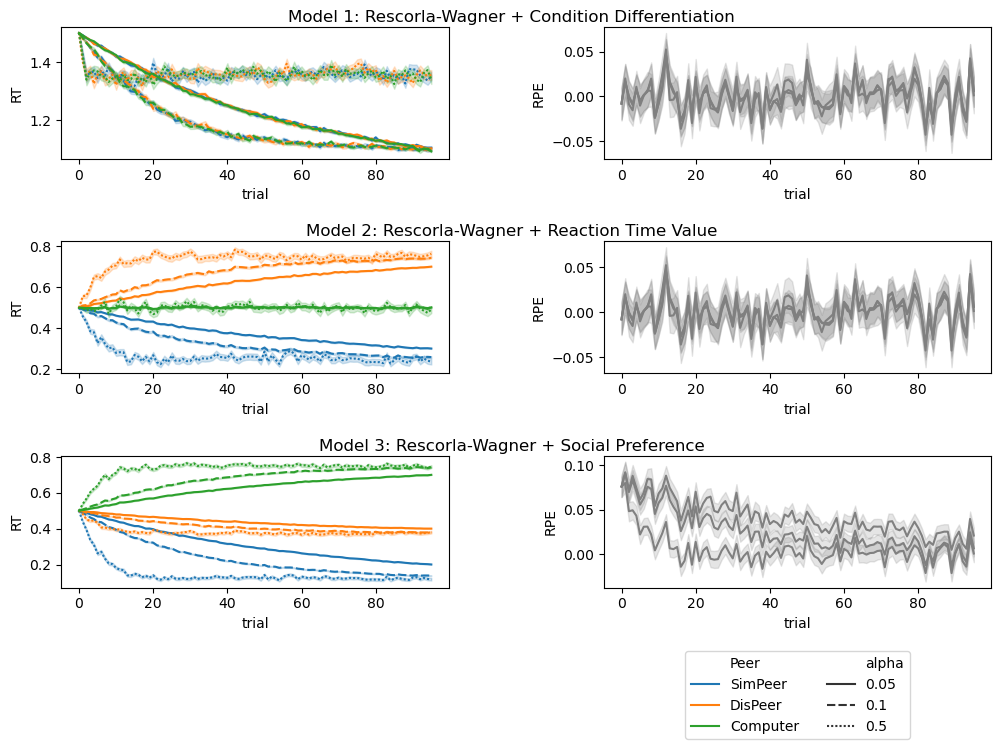

In [8]:
relv_models = [model_3_long, model_4_long, model_8_long]
relv_titles = ['Model 1: Rescorla-Wagner + Condition Differentiation',
               'Model 2: Rescorla-Wagner + Reaction Time Value', 
               'Model 3: Rescorla-Wagner + Social Preference']

palette = {'SimPeer':sns.color_palette()[0],
           'DisPeer':sns.color_palette()[1],
           'Computer':sns.color_palette()[2]}

fig = plt.figure(figsize=(12,2*len(relv_models)))
#fig.suptitle('Figure title')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=len(relv_models), ncols=1, hspace=0.25)
#subfigs.subplots_adjust(hspace=2)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(relv_titles[row])
    plt.subplots_adjust(wspace=0.4)

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
        #ax.plot()
        #ax.set_title(f'Plot title {col}')

    # Plot Value
    #sns.lineplot(data=relv_models[row], x='trial', y='Value', dashes=False, 
    #             hue='Condition', style='alpha', ax=axs[0])
    #axs[0].set_ylabel('Value')

    
    #axs[row,0].set_title(relv_titles[i])
        
        
    # Plot reaction time
    sns.lineplot(data=relv_models[row], x='trial', y='RT', 
                 hue='Peer', style='alpha', ax=axs[0], palette=palette)
    axs[0].set_ylabel('RT')

    if row == len(relv_models)-1:
        plt.setp(axs[0].get_legend().legend_handles, markeredgewidth=1)
        sns.move_legend(axs[0], "lower center", bbox_to_anchor=(1.9, -1.2), ncol = 2)
        #sns.move_legend(axs[0], "lower center", bbox_to_anchor=(1.9, -1), 
        #           labels=['Similar Peer','Dissimilar Peer','Computer'], ncol=3)
    else:
        axs[0].get_legend().remove()
        
        
    # Plot reward prediction error
    sns.lineplot(data=relv_models[row], x='trial', y='RPE', style='alpha',
                 dashes=False, ax=axs[1], color='grey')
    axs[1].get_legend().remove()
    axs[1].set_ylabel('RPE')

### Simulation Summary
- Model 1
  - Value is calculated along with a RPE based solely on the feedback received
  - **Note:** I am just including this for now because this is the model I used on my SANS poster last year
- Model 2
  - This model produces random reaction times that do not seem to effect value
- Model 3
  - This model produces quicker reaction times for each condition, as the value of the conditions are learned
- Model 4
  - This model shows a negative relationship between reaction time and value, as hypothesized
- Model 5
  - This model inflates the reaction time of the computer and dissimilar peer conditions
  - It was meant to be similar to Model 4, but with the dissimilar peer reaction time being similar to the similar peer
  - **Note:** Need help with the math for this one
- Model 6
  - This model seems to start off over or under-inflating reaction times due to the item value multiplier
  - Using 2 and -2 for really like and really dislike may be too extreme
- Model 7
  - This model was meant to make the dissimilar peer and similar peer reaction times be more similar, but failed
  - Drop this model
- Model 8
  - This model was meant to make the dissimilar peer and similar peer reaction times be more similar, but failed
  - Drop this model

**Note:** Model 5 is wrong. I am not getting the math right and I need to check with Caroline. Model 6 doesn't indicate learning. Maybe the item value "amplifier" is too much (e.g. 1 and 2), when it should be less (e.g. 1 and 1.5)?

## Model Fitting
Now we will try to determine the parameters of interest from an individual participant's data. We will attempt to get a value for their learning rate (alpha) and their reaction time parameter (beta). **Note:** Right now, we are doing to do this for Models 2 and 3, since they are kind of null models and I just want to see if I am doing these modeling steps correctly, before testing out actual hypothesis models. 